### Objective
`Prediction of Molecular Properties:` To build a machine learning model that can accurately predict the HOMO-LUMO gap based on a given molecule's quantum properties.

- `Dataset`: Transition Metals Quantum Chemistry `tmQM`

In [1]:
# importing libraries
# for xyz file
from ase.io import read, write
from ase import Atoms
from ase.io import read
from ase.visualize import view

from rdkit import Chem  
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# for cvs file
import pandas as pd,  numpy as np, os
working_directory = os.getcwd()

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

`tmQM_X1` and `tmQM_X2`: 
- Contains the Cartesian coordinates of all metal complexes optimized at the GFN2-xTB level in .xyz format.

- Additional information such as the molecular size, CSD code, charge, spin, stoichiometry and metal node degree is also included

In [69]:
# read all the atoms in the XYZ file into an Atoms object
cmpds1_xyz = read(working_directory+'/tmQM_X1.xyz')
print(len(cmpds1_xyz))
# print information about the transition compounds
cmpds1_xyz.info 

116


{'CSD_code': 'WIXKOE',
 '|': True,
 'q': 0,
 'S': 0,
 'Stoichiometry': 'C47H65LaN2O',
 'MND': 7}

In [70]:
# read all the atoms in the XYZ file into an Atoms object
cmpds2_xyz = read(working_directory+'/tmQM_X2.xyz')
print(len(cmpds2_xyz))
# print information about the transition compounds
cmpds2_xyz.info

77


{'CSD_code': 'GIQVAG',
 '|': True,
 'q': 0,
 'S': 0,
 'Stoichiometry': 'C41H31IrN2O2',
 'MND': 6}

This is a dictionary data structure in Python. Each entry in the dictionary consists of a key-value pair. Here is what each key-value pair in this dictionary indicates:

`CSD_code`: 'WIXKOE': This indicates that the Cambridge Structural Database (CSD) code for this molecule is 'WIXKOE'. The CSD code is a unique identifier used to look up information about the molecule in the CSD.

`|`: True: The '|' character here seems to be used as a key, but without context, it's hard to definitively say what it signifies. Usually, such keys are used to denote specific conditions or flags that are either True or False.

`q`: 0: This indicates that the net electric charge of the molecule is 0.

`S`: 0: This indicates that the total spin quantum number of the molecule is 0. The spin quantum number is a measure of the angular momentum intrinsic to a particle.

`Stoichiometry`: 'C47H65LaN2O': This tells you the stoichiometric formula of the molecule, indicating it consists of 47 Carbon atoms, 65 Hydrogen atoms, 1 Lanthanum atom, 2 Nitrogen atoms, and 1 Oxygen atom.

`MND`: 7: 'MND' could stand for 'Metal Node Degree', which indicates the connectivity of the metal atom within the structure. A MND of 7 suggests that the metal atom forms seven connections.

> - Converting the XYZ data to an RDKit molecule is almost not doable unless we know the atoms connectivity and bonds information. Luckily I found that RDKit has recently imlemented xyz2mol. 

refrences:

https://github.com/jensengroup/xyz2mol

https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html , 

https://rdkit.org/docs/source/rdkit.Chem.rdDetermineBonds.html#rdkit.Chem.rdDetermineBonds.DetermineConnectivity


In [80]:
# clone xyz2mol

#! git clone https://github.com/jensengroup/xyz2mol

In [76]:
# Read all structures from the XYZ file
all_structures = read(working_directory+'/tmQM_X1.xyz', index=':') 
# Select the first compound
first_compound = all_structures[0]

# Visualize the first compound
view(first_compound, viewer="x3d")

In [ ]:
raw_mols = Chem.rdmolfiles.MolFromXYZFile(working_directory+'/tmQM_X2.xyz') 
c2 = raw_mols[2]

Chem.Draw.MolToImage(c2, size=(600,600))

In [2]:
# read csv data
tmqm_data = pd.read_csv(working_directory+'/tmQM_y.csv', sep=';', header=0)

In [82]:
tmqm_data.head()

,CSD_code,Electronic_E,Dispersion_E,Dipole_M,Metal_q,HL_Gap,HOMO_Energy,LUMO_Energy,Polarizability
0,WIXKOE,-2045.524942,-0.239239,4.2333,2.10934,0.13108,-0.16204,-0.03096,598.457913
1,DUCVIG,-2430.690317,-0.082134,11.7544,0.75994,0.12493,-0.24358,-0.11865,277.750698
2,KINJOG,-3467.923206,-0.137954,8.3017,1.76650,0.14014,-0.23646,-0.09632,393.442545
3,GEKYEC,-3657.137747,-0.073924,3.0448,1.17186,0.13865,-0.26765,-0.12900,266.725736
4,PIBNEV,-1184.911899,-0.132369,2.7760,1.92642,0.10641,-0.15164,-0.04523,342.341585


### Data description:
The dataset is based on `Density Functional Theory (DFT)` calculations and encompasses a wide range of molecular properties.

`CSD_code:` Cambridge Structural Database code for the transition metals compounds.

`Electronic Energy:` This is the energy of the system considering the interactions between electrons and atomic nuclei. It plays a crucial role in understanding molecular stability, molecular reactions, and physical properties of the system.

`Dispersion Energy:` This is the energy associated with Van der Waals forces - weak attractions or repulsions between molecules or parts of the same molecule due to transient polarization of particles.

`Dipole Moment:` This is a measure of the overall polarity of a molecule, which can influence the molecule's interactions with electric fields and other molecules.

`Natural Charge of the Metal Center:` This refers to the charge of the metal atom in a molecule, typically in a coordination complex.

`HOMO-LUMO gap:` The gap between the highest occupied molecular orbital (HOMO) and the lowest unoccupied molecular orbital (LUMO) is critical for determining a molecule's reactivity and stability.

`HOMO energy & LUMO energy:` The energies of the HOMO and LUMO are essential in chemical reactivity and the color of compounds.

`Polarizability:` This is a measure of how the electron cloud around an atom responds to changes in its electronic environment.

# 1- Exploring the Data (EDA)

In [4]:
tmqm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86665 entries, 0 to 86664
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CSD_code        86665 non-null  object 
 1   Electronic_E    86665 non-null  float64
 2   Dispersion_E    86665 non-null  float64
 3   Dipole_M        86665 non-null  float64
 4   Metal_q         86665 non-null  float64
 5   HL_Gap          86665 non-null  float64
 6   HOMO_Energy     86665 non-null  float64
 7   LUMO_Energy     86665 non-null  float64
 8   Polarizability  86665 non-null  float64
dtypes: float64(8), object(1)
memory usage: 6.0+ MB


Comment:

> - The number of missing values is 0

In [5]:
# check duplicates
tmqm_data['CSD_code'].duplicated().sum()

0

In [6]:
# summary statistics
tmqm_data.describe()

,Electronic_E,Dispersion_E,Dipole_M,Metal_q,HL_Gap,HOMO_Energy,LUMO_Energy,Polarizability
count,86665.000000,86665.000000,86665.000000,86665.000000,86665.000000,86665.00000,86665.000000,86665.000000
mean,-2952.142984,-0.141043,5.746084,0.150391,0.109266,-0.19830,-0.089034,393.512906
std,1608.798073,0.069794,3.889717,0.795228,0.033881,0.05426,0.055013,151.791233
min,-29008.530471,-1.122263,0.000000,-3.083370,0.002220,-0.44203,-0.377320,51.249960
25%,-3509.813920,-0.178652,2.935200,-0.263330,0.088560,-0.21133,-0.108140,282.781464
50%,-2659.883034,-0.128506,5.330800,0.243520,0.110170,-0.18725,-0.078640,369.386770
75%,-1944.605342,-0.089613,8.137900,0.663900,0.130540,-0.16878,-0.055990,478.148414
max,-295.243567,-0.004936,81.698500,2.330130,0.307420,0.03984,0.198190,3002.513834


Comment:

> - The `Mean` and the `50% values` are somehow `close`, `could suggest` that the data is `not skewed.`

- The 25% (Q1), 50% (median), and 75% (Q3) are 0.0886, 0.1102, and 0.1305 respectively
Based on these, we can calculate the IQR for HL_Gap:

IQR = Q3 - Q1 = 0.1305 - 0.0886 = 0.0419

And then find the lower and upper bounds:

. Lower bound = Q1 - 1.5IQR = 0.0886 - 1.50.0419 = 0.0271

. Upper bound = Q3 + 1.5IQR = 0.1305 + 1.50.0419 = 0.1920 

> - Since the `min` and `max` of HL_Gap are within these bounds, there are `likely no outliers` according to this method.

> - From the `std` and the `mean`, not all the variables centered around 0, so we will need to `standardize/scale the features before modeling`.

<AxesSubplot:xlabel='HL_Gap', ylabel='Count'>

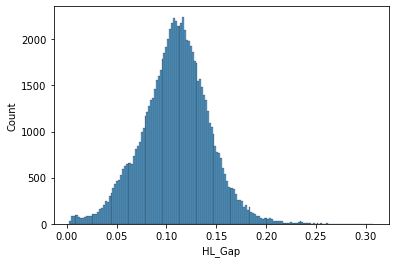

In [7]:
# target variable distribution
sns.histplot(tmqm_data['HL_Gap'])

In [15]:
#skewness and kurtosis
print("Skewness: %f" % tmqm_data['HL_Gap'].skew())
print("Kurtosis: %f" % tmqm_data['HL_Gap'].kurt())

Skewness: -0.012297
Kurtosis: 0.636767


> - The `skewness` is -0.012297 which is very close to 0. This indicates that our target variable, HL_Gap, distribution is `approximately symmetric`, with a `slight skew to the left (since it's negative)`.

> - The `kurtosis` is 0.636767 which is greater than 0. This indicates that the HL_Gap distribution is leptokurtic, meaning it `has heavier tails and a sharper peak than a normal distribution.`

> - `If the data was skewed`, it can sometimes cause problems for certain types of analyses that assume a normal distribution (like linear regression). In this case, you might want to `apply a transformation` to the data to make it more symmetrical e.g., Log transformation, or square root transformation ... (depends if the data is positively or negatively skewd, has zeros or not)

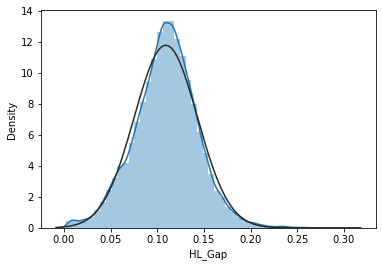

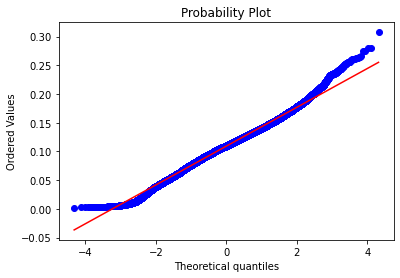

In [18]:
#histogram and normal probability plot
sns.distplot(tmqm_data['HL_Gap'], fit=norm);
fig = plt.figure()
res = stats.probplot(tmqm_data['HL_Gap'], plot=plt)

Comment:

First graph: Overlaid on this histogram is the bell curve, or the normal distribution. If the data is `normally distributed`, the `histogram should resemble the bell curve`. 

Second graph: Probability Plot (QQ Plot): In this plot, the quantiles of target variable's distribution is plotted against the quantiles of the normal distribution. The ideal outcome is that the data points will fall along the 45-degree reference line. If the plotted quantiles from the data diverge from the line, your data is not normally distributed.

<AxesSubplot:ylabel='HL_Gap'>

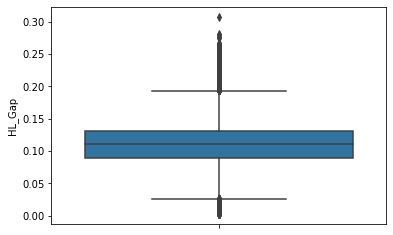

In [26]:
# visualize the outliers
sns.boxplot(y=tmqm_data['HL_Gap'])

In [3]:
# standardizing data

HL_gap_scaled = StandardScaler().fit_transform(tmqm_data['HL_Gap'][:,np.newaxis])
low_range = HL_gap_scaled[HL_gap_scaled[:,0].argsort()][:10]
high_range= HL_gap_scaled[HL_gap_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-3.1595266 ]
 [-3.14919616]
 [-3.14831069]
 [-3.14417851]
 [-3.14211242]
 [-3.13207713]
 [-3.13030619]
 [-3.12883041]
 [-3.12381277]
 [-3.12322246]]

outer range (high) of the distribution:
[[4.51599675]
 [4.53842859]
 [4.56941993]
 [4.59450816]
 [4.630222  ]
 [4.88759775]
 [4.90766834]
 [5.01687594]
 [5.04432541]
 [5.84862463]]


/var/folders/3r/rhzmby3914s7l0nkcc1jk7h80000gq/T/ipykernel_12130/1723799806.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  HL_gap_scaled = StandardScaler().fit_transform(tmqm_data['HL_Gap'][:,np.newaxis])


In [4]:
scaler = StandardScaler()
std_data = scaler.fit_transform(tmqm_data[['Electronic_E','Dipole_M','HL_Gap', 'Polarizability']])#[:,np.newaxis])
df_std = pd.DataFrame(std_data, columns=['Electronic_E','Dipole_M','HL_Gap', 'Polarizability'])
df_std

,Electronic_E,Dipole_M,HL_Gap,Polarizability
0,0.563541,-0.388921,0.643849,1.350185
1,0.324127,1.544676,0.462329,-0.762645
2,-0.320602,0.657022,0.911260,-0.000464
3,-0.438215,-0.694472,0.867282,-0.835278
4,1.098485,-0.763578,-0.084300,-0.337118
...,...,...,...,...
86660,-0.636516,0.803435,0.735938,-0.296976
86661,0.072072,0.154104,-0.934938,-0.056880
86662,-1.028839,1.248714,-1.189362,-0.105050
86663,0.908504,-0.332361,-0.513751,-1.006357


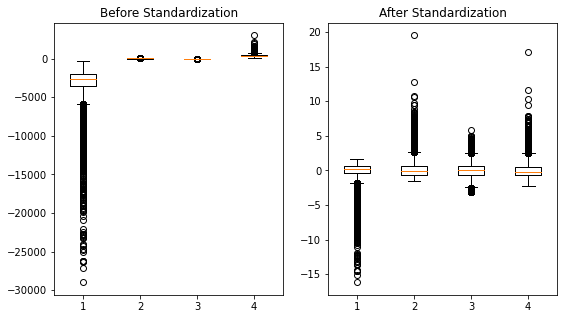

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,5))
ax1.boxplot(tmqm_data[['Electronic_E','Dipole_M','HL_Gap', 'Polarizability']]);
ax1.set_title('Before Standardization')
ax2.boxplot(df_std[['Electronic_E','Dipole_M','HL_Gap', 'Polarizability']]);
ax2.set_title('After Standardization');

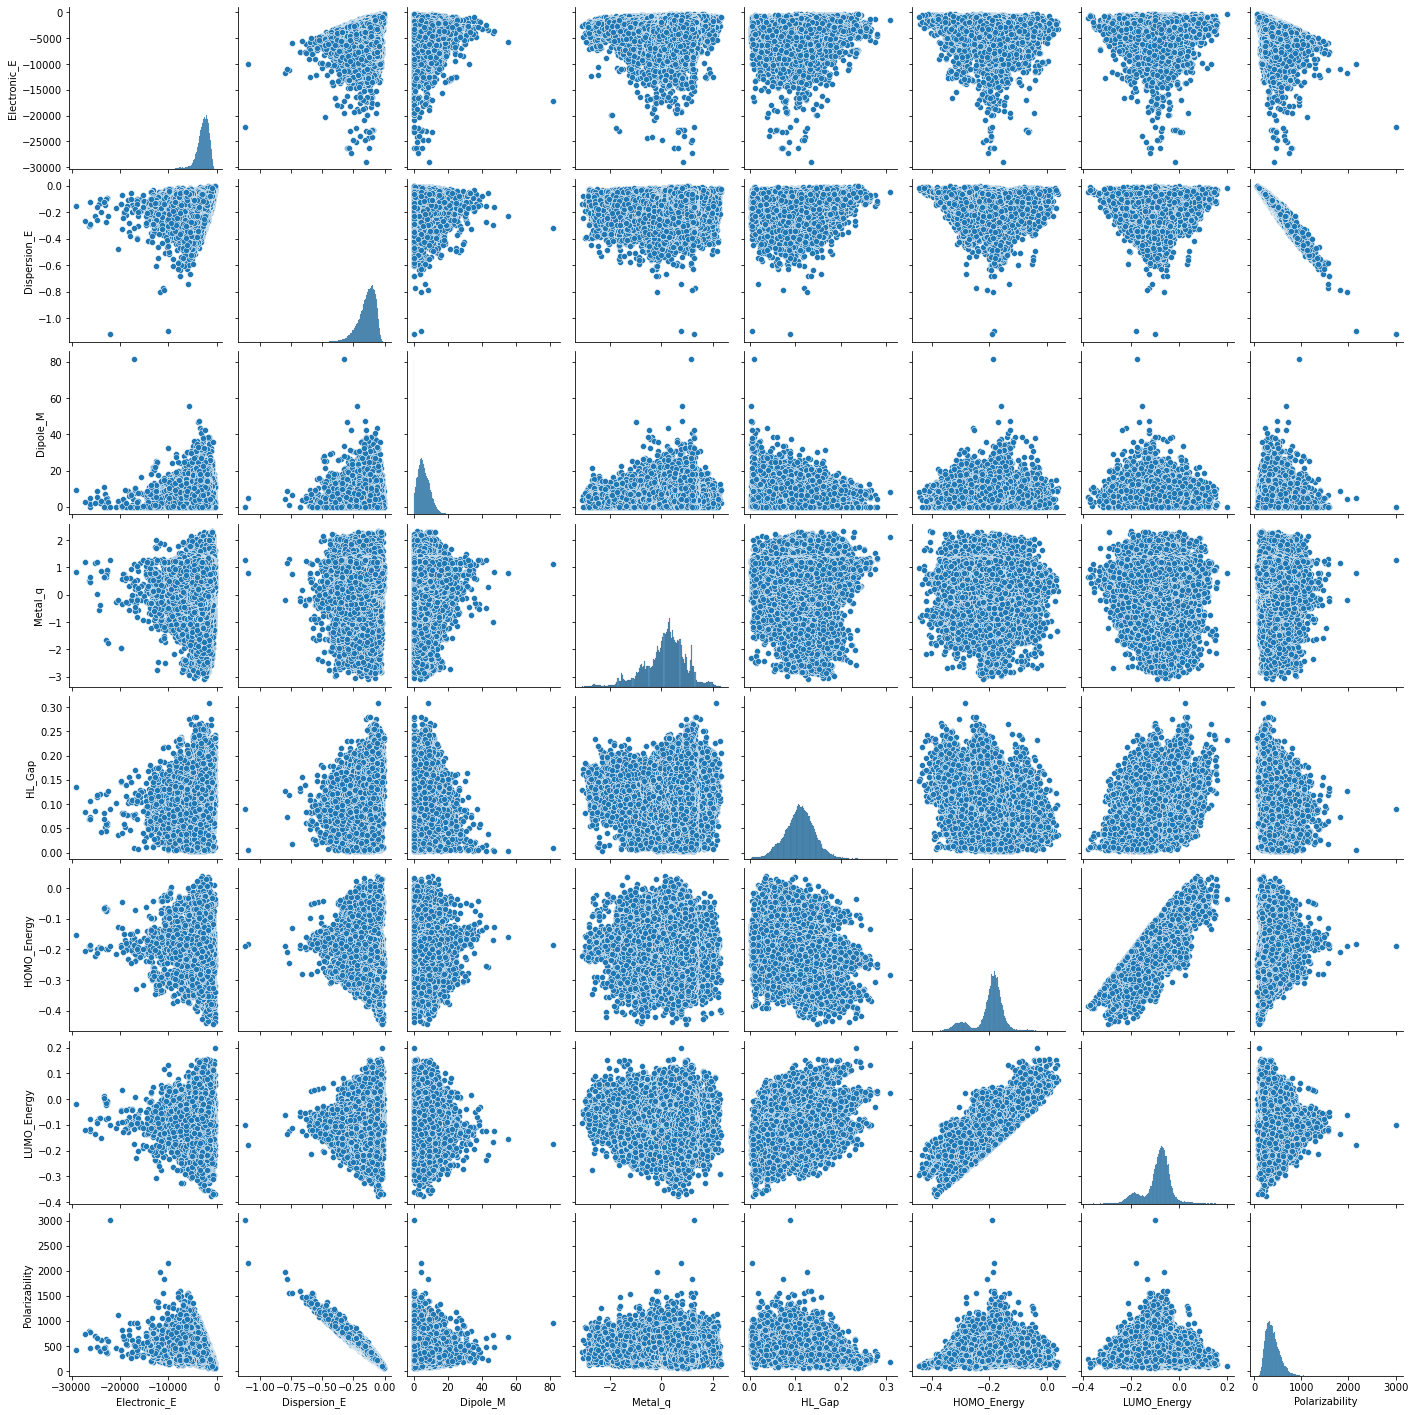

In [36]:
# Pairplot to understand the pattern trends/relationships between the variables as well astheir distributions
sns.pairplot(tmqm_data)

What can we see here?
- `Distribution of single variables:` The histograms/density plots along the diagonal allow you to see the distribution of a single variable. You can identify the shape of the distribution `(e.g., normal, skewed)`, presence of outliers, and if there are gaps or unusual values in the data.

- `Relationships between variables:` The scatter plots in the off-diagonal cells help understand the relationships between pairs of variables. `If a clear pattern (e.g., linear, quadratic) is visible, it suggests a strong correlation between the variables. If no pattern is visible or points are randomly spread, it suggests that variables are not correlated.`

- `Identifying types of relationships:` The pairplot can also help in identifying if the relationship between variables is `linear or non-linear.` (- A correlation value close to 1 or -1 indicates a strong linear relationship, while a value close to 0 indicates a weak or non linear relationship.)

- `Identifying potential outliers:` Outliers can be spotted if certain points in scatter plots are far away from the others.


Comment: 

> - Linear relationship with HOMO_Energy and LUMO_Energy. It is negative with the former and positive with the later. 

> - The other features, "Electronic_E", "Dispersion_E", "Dipole_M", "Metal_q", and "Polarizability", have relatively low correlation values, meaning they might have a weaker linear relationship with the "HL_Gap".

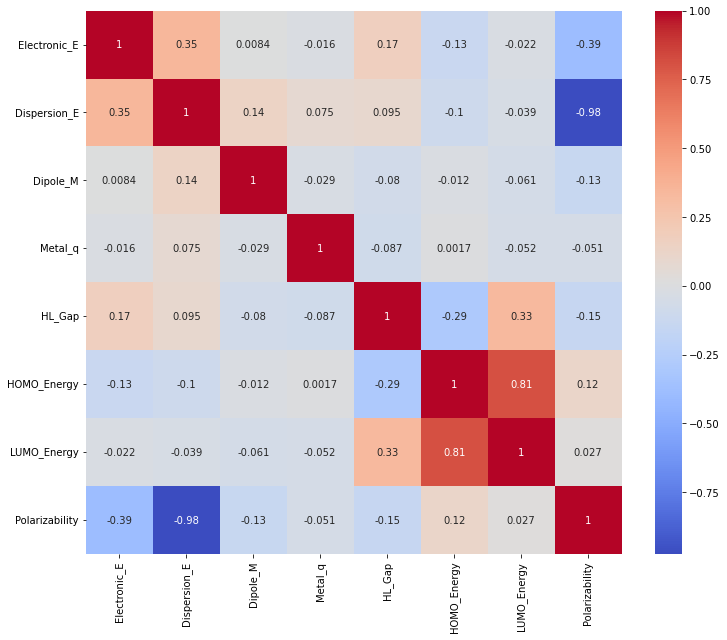

In [14]:
# Correlation Matrix: HeatMap
plt.figure(figsize=(12, 10))
sns.heatmap(tmqm_data.corr(), annot=True, cmap='coolwarm')
plt.show()

>- Based on the given correlation values, the features "HOMO_Energy" and "LUMO_Energy" seem to have the strongest linear relationships with "HL_Gap" as they have the highest absolute values of correlation (0.29 and 0.33 respectively). The negative correlation for "HOMO_Energy" means that as "HOMO_Energy" increases, the "HL_Gap" tends to decrease, and the positive correlation for "LUMO_Energy" means that as "LUMO_Energy" increases, the "HL_Gap" tends to increase.

>- The other features, "Electronic_E", "Dispersion_E", "Dipole_M", "Metal_q", and "Polarizability", have relatively low correlation values, meaning they might have a weaker linear relationship with the "HL_Gap".

>- However, correlation does not imply causation, and a low correlation does not necessarily mean that the feature is not important. It's also worth noting that machine learning algorithms can capture complex, non-linear relationships between features and the target variable, so features with low linear correlation could still be relevant in the context of a machine learning model.